
# 01 — Descriptive Statistics for Two Quantitative Variables (Python & Jupyter)

This notebook helps you **load a CSV or XLSX file**, pick **two quantitative columns**, and compute **descriptive statistics** and **basic visualizations**.

**What you will get:**
- Robust data loader (CSV/XLSX) with helpful diagnostics
- Selection prompts for two columns
- Descriptive summary (count, mean, std, quartiles, min, max)
- Missing-values checks
- Histograms and boxplots (each in a separate figure)
- Scatter plot + Pearson and Spearman correlations
- Short textual guidance in plain English


## Step 0 — Environment check

In [5]:

import sys

required = ["pandas", "numpy", "matplotlib", "openpyxl"]
missing = []
for mod in required:
    try:
        __import__(mod)
    except Exception:
        missing.append(mod)

if missing:
    print("Missing required modules:", ", ".join(missing))
    print("Please install them, for example:")
    print("  pip install " + " ".join(missing))
    raise SystemExit("Install the missing modules, then re-run this notebook.")
else:
    print("All required modules found. Proceed.")


All required modules found. Proceed.


## Step 1 — Imports & configuration

In [6]:

import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Matplotlib defaults (no specific colors/styles as per course policy)
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = True

print("Working directory:", os.getcwd())
print("Files here (first 100):")
for p in sorted(glob.glob("*"))[:100]:
    print(" -", p)


Working directory: /home/wiwern/Dokumenty/wiktor2.0/Data_analysis_for_historians_Wiktor_Werner_1
Files here (first 100):
 - 01_descriptive_statistics.ipynb
 - 02_eda_linear_regression.ipynb
 - 03_time_series_analysis.ipynb
 - 03b_time_series_causal_analysis.ipynb
 - 04_correspondence_analysis.ipynb
 - 05_directed_network_analysis.ipynb
 - AMZN.csv
 - INSTALLATION_en_es.md
 - LICENSE
 - README.md
 - course_overview.md
 - czasopisma.csv
 - instrukcja
 - opis.md
 - qrcode_github.com.png
 - qrcode_zenodo.org.png
 - time_series_analysis.ipynb


## Step 2 — Load a CSV/XLSX file (smart loader)

In [7]:

def smart_load_table():
    """Interactive loader for CSV/XLSX with helpful diagnostics.
    - Asks for a file path.
    - If Excel: lists sheets and lets you choose.
    - If CSV: tries to auto-detect separator/encoding; falls back to common settings (sep=';', decimal=',').
    Returns: DataFrame
    """
    path = input("Enter file name or full path (.csv / .xlsx): ").strip()
    if not path:
        raise SystemExit("No file provided.")
    
    # Excel case
    if path.lower().endswith((".xlsx", ".xls")):
        try:
            import openpyxl  # ensure engine available
        except Exception:
            print("openpyxl is required for .xlsx. Install: pip install openpyxl")
            raise
        try:
            xl = pd.ExcelFile(path)
        except FileNotFoundError:
            print(f"File not found: {path}")
            raise
        sheets = xl.sheet_names
        print("Available sheets:", sheets)
        sheet = input("Sheet name (leave empty for first): ").strip() or sheets[0]
        try:
            df = pd.read_excel(path, sheet_name=sheet)
        except ValueError as e:
            print("Invalid sheet name. Available:", sheets)
            raise
        print(f"Loaded Excel sheet: {sheet}")
    
    # CSV case
    elif path.lower().endswith(".csv"):
        # Try autodetect separator (engine='python') with UTF-8
        try:
            df = pd.read_csv(path, sep=None, engine="python")
            print("Loaded CSV with autodetected separator and UTF-8 encoding.")
        except UnicodeDecodeError:
            # Try common encodings for PL/EU contexts
            for enc in ("utf-8-sig", "cp1250", "latin-1"):
                try:
                    df = pd.read_csv(path, sep=None, engine="python", encoding=enc)
                    print(f"Loaded CSV with autodetected separator and encoding={enc}.")
                    break
                except Exception:
                    df = None
            if df is None:
                print("Could not decode CSV with common encodings (utf-8-sig, cp1250, latin-1).")
                raise
        except Exception as e:
            # Fallback: common Polish CSV settings
            try:
                df = pd.read_csv(path, sep=";", decimal=",")
                print("Loaded CSV with sep=';' and decimal=',' (encoding autodetected).")
            except Exception as e2:
                print("Autodetect and fallback failed.")
                print("Original error:", repr(e))
                print("Fallback error:", repr(e2))
                print("Tips: check delimiter (',' or ';'), encoding (utf-8, utf-8-sig, cp1250), decimal ('.' or ',').")
                raise
    else:
        raise SystemExit("Unsupported file type. Use .csv or .xlsx/.xls.")
    
    # Clean column names (strip + remove BOM)
    df.columns = [str(c).encode("utf-8", "ignore").decode("utf-8").strip().lstrip("\ufeff") for c in df.columns]
    
    print("\nShape:", df.shape)
    print("Columns:", list(df.columns))
    display(df.head(10))
    print("\nDtypes:")
    print(df.dtypes)
    
    if df.shape[1] > 50:
        print("\nWARNING: More than 50 columns. If this looks wrong, your delimiter is likely incorrect.")
    
    return df

# Run the loader
df = smart_load_table()


Enter file name or full path (.csv / .xlsx):  AMZN.csv


Loaded CSV with autodetected separator and UTF-8 encoding.

Shape: (253, 7)
Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-10-16,1773.33,1786.24,1770.52,1777.43,1777.43,2763400
1,2019-10-17,1796.49,1798.85,1782.02,1787.48,1787.48,2647400
2,2019-10-18,1787.80,1793.98,1749.20,1757.51,1757.51,3362500
3,2019-10-21,1769.66,1785.88,1765.00,1785.66,1785.66,2130400
4,2019-10-22,1788.15,1789.78,1762.00,1765.73,1765.73,2111700
5,2019-10-23,1761.30,1770.05,1742.00,1762.17,1762.17,2138200
6,2019-10-24,1771.09,1788.34,1760.27,1780.78,1780.78,4446100
7,2019-10-25,1697.55,1764.21,1695.00,1761.33,1761.33,9626400
8,2019-10-28,1748.06,1778.70,1742.50,1777.08,1777.08,3708900
9,2019-10-29,1774.81,1777.00,1755.81,1762.71,1762.71,2276900



Dtypes:
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


## Step 3 — Select two quantitative columns

In [8]:

print("Available columns:", list(df.columns))

def ask_col(prompt):
    while True:
        col = input(prompt).strip()
        if col in df.columns:
            return col
        print(f"Column '{col}' not found. Try again. Available: {list(df.columns)}")

col_x = ask_col("Enter the FIRST quantitative column name: ")
col_y = ask_col("Enter the SECOND quantitative column name: ")

# Make a working copy
work = df[[col_x, col_y]].copy()

# Coerce to numeric (non-numeric -> NaN)
for c in [col_x, col_y]:
    work[c] = pd.to_numeric(work[c], errors="coerce")

print("\nAfter numeric coercion:")
display(work.head(10))

# Missing values report
na_report = work.isna().sum()
print("\nMissing values per column:")
print(na_report)

# Drop rows where both are NaN (keep rows if at least one present for some operations)
work_pairwise = work.dropna(subset=[col_x, col_y], how="any")
print("\nRows with both numeric present:", len(work_pairwise), "of", len(work))
if len(work_pairwise) < 5:
    print("WARNING: Very few valid rows for pairwise analysis. Results may be unstable.")


Available columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


Enter the FIRST quantitative column name:  Open
Enter the SECOND quantitative column name:  Close



After numeric coercion:


,Open,Close
0,1773.33,1777.43
1,1796.49,1787.48
2,1787.80,1757.51
3,1769.66,1785.66
4,1788.15,1765.73
5,1761.30,1762.17
6,1771.09,1780.78
7,1697.55,1761.33
8,1748.06,1777.08
9,1774.81,1762.71



Missing values per column:
Open     0
Close    0
dtype: int64

Rows with both numeric present: 253 of 253


## Step 4 — Descriptive statistics

In [9]:

desc = work.describe(percentiles=[0.25, 0.5, 0.75]).T
print("Descriptive statistics (after numeric coercion):")
display(desc)

print("\nPlain-English guidance:")
print(f"- '{col_x}' and '{col_y}' are analyzed as numeric variables (non-numeric values were set to NaN).")
print("- Check 'count': if it is much smaller than the total number of rows, your column might contain many non-numeric entries.")
print("- Compare mean vs. median (50%) to gauge skewness; large differences may indicate skewed distributions or outliers.")
print("- The IQR (75% - 25%) shows dispersion around the median; combine with std for spread.")


Descriptive statistics (after numeric coercion):


,count,mean,std,min,25%,50%,75%,max
Open,253.0,2386.007194,577.490322,1641.51,1860.00,2329.44,3022.61,3547.00
Close,253.0,2388.005296,574.837504,1676.61,1862.02,2314.08,3008.87,3531.45



Plain-English guidance:
- 'Open' and 'Close' are analyzed as numeric variables (non-numeric values were set to NaN).
- Check 'count': if it is much smaller than the total number of rows, your column might contain many non-numeric entries.
- Compare mean vs. median (50%) to gauge skewness; large differences may indicate skewed distributions or outliers.
- The IQR (75% - 25%) shows dispersion around the median; combine with std for spread.


## Step 5 — Distributions: histograms and boxplots

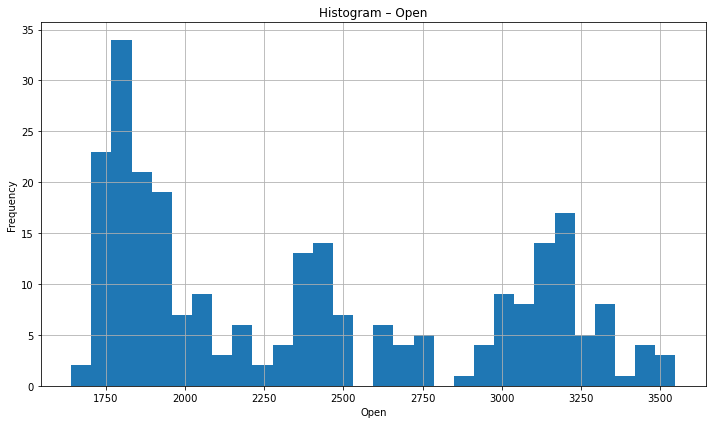

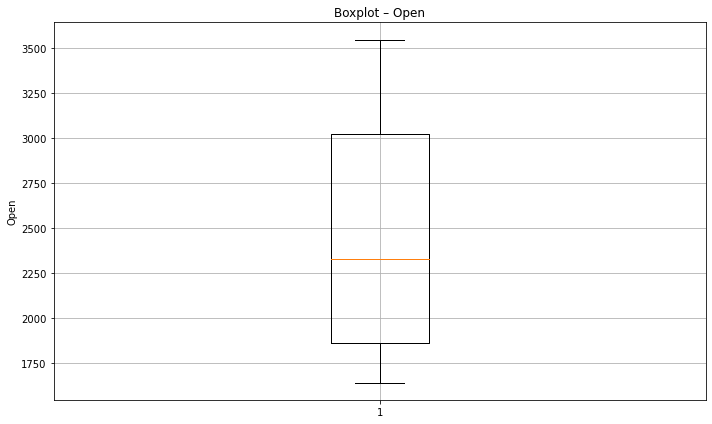

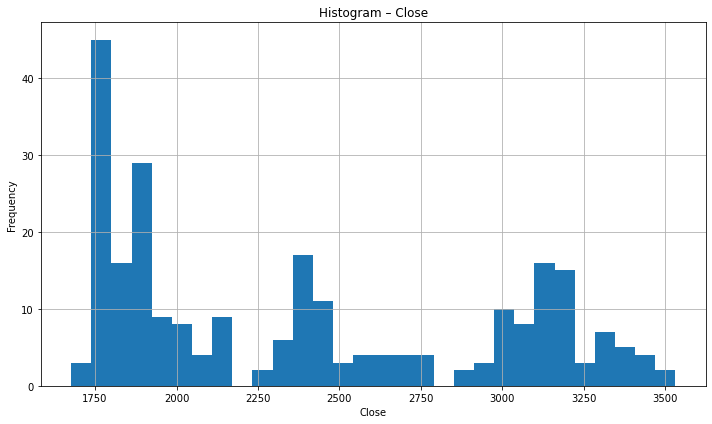

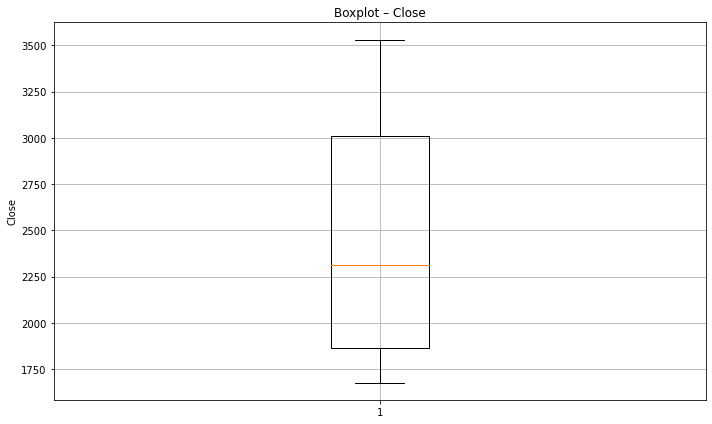

Interpretation tips:
- Histograms show the overall shape (symmetry, skewness, potential multimodality).
- Boxplots highlight median and the spread (IQR), and make outliers visible.


In [10]:

import matplotlib.pyplot as plt

# Histogram X
plt.figure()
work[col_x].dropna().plot(kind="hist", bins=30)
plt.title(f"Histogram – {col_x}")
plt.xlabel(col_x)
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Boxplot X
plt.figure()
plt.boxplot(work[col_x].dropna().values, vert=True)
plt.title(f"Boxplot – {col_x}")
plt.ylabel(col_x)
plt.tight_layout()
plt.show()

# Histogram Y
plt.figure()
work[col_y].dropna().plot(kind="hist", bins=30)
plt.title(f"Histogram – {col_y}")
plt.xlabel(col_y)
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Boxplot Y
plt.figure()
plt.boxplot(work[col_y].dropna().values, vert=True)
plt.title(f"Boxplot – {col_y}")
plt.ylabel(col_y)
plt.tight_layout()
plt.show()

print("Interpretation tips:")
print("- Histograms show the overall shape (symmetry, skewness, potential multimodality).")
print("- Boxplots highlight median and the spread (IQR), and make outliers visible.")


## Step 6 — Scatter plot and correlations

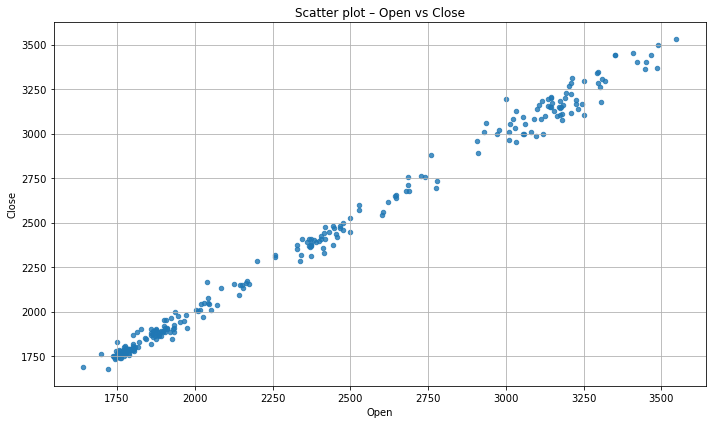

Correlations:
- Pearson r = 0.9968 (p = 3.34e-278)
- Spearman rho = 0.9902 (p = 9.27e-217)


In [11]:

pair = work_pairwise  # rows where both variables are present

if len(pair) >= 2:
    # Scatter
    plt.figure()
    plt.scatter(pair[col_x].values, pair[col_y].values, s=20, alpha=0.8)
    plt.title(f"Scatter plot – {col_x} vs {col_y}")
    plt.xlabel(col_x)
    plt.ylabel(col_y)
    plt.tight_layout()
    plt.show()

    # Pearson and Spearman
    from scipy.stats import pearsonr, spearmanr
    try:
        pear = pearsonr(pair[col_x].values, pair[col_y].values)
        spear = spearmanr(pair[col_x].values, pair[col_y].values)
        print("Correlations:")
        print(f"- Pearson r = {pear.statistic:.4f} (p = {pear.pvalue:.2e})")
        print(f"- Spearman rho = {spear.correlation:.4f} (p = {spear.pvalue:.2e})")
    except Exception as e:
        print("Correlation computation failed:", repr(e))
        print("Ensure both columns are numeric and have some variability.")
else:
    print("Not enough valid paired rows for a scatter plot / correlations.")
